Over the summer, I took on this coding project as a way to dive into the world of market microstructure. I was inspired by the book "Algorithmic and High-Frequency Trading" by Cartea, Jaimungal, and Penalva, and I wanted to explore how concepts from this book could be practically implemented. I decided to incorporate bandit algorithms and some basic reinforcement learning techniques into my project to better understand market microstructure dynamics.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class BaseAgent:
    def __init__(self, id):
        self.id = id

    def place_order(self, order_book):
        pass

In [ ]:
class LimitOrderBook:
    def __init__(self):
        self.buy_orders = []
        self.sell_orders = []
        self.historical_prices = []
        self.inventories = {}

    def add_order(self, price, qty, side, agent_id):
        price_impact = 0.01 * qty  # 1% price impact per unit quantity
        adjusted_price = price + price_impact if side == 'buy' else price - price_impact

        order = {'price': adjusted_price, 'qty': qty, 'agent_id': agent_id}
        if side == 'buy':
            self.buy_orders.append(order)
            self.buy_orders = sorted(self.buy_orders, key=lambda x: x['price'], reverse=True)
        else:
            self.sell_orders.append(order)
            self.sell_orders = sorted(self.sell_orders, key=lambda x: x['price'])

        if agent_id not in self.inventories:
            self.inventories[agent_id] = 0
        self.inventories[agent_id] += qty if side == 'buy' else -qty

    def match_orders(self):
        while self.buy_orders and self.sell_orders:
            best_buy = self.buy_orders[0]
            best_sell = self.sell_orders[0]
            if best_buy['price'] >= best_sell['price']:
                qty = min(best_buy['qty'], best_sell['qty'])
                best_buy['qty'] -= qty
                best_sell['qty'] -= qty
                self.historical_prices.append(best_sell['price'])

                if best_buy['qty'] == 0:
                    self.buy_orders.pop(0)
                if best_sell['qty'] == 0:
                    self.sell_orders.pop(0)
            else:
                break

    def expire_orders(self, time_step, max_order_age):
        # Remove orders that have remained unmatched for too long
        self.buy_orders = [order for order in self.buy_orders if time_step - order['time'] <= max_order_age]
        self.sell_orders = [order for order in self.sell_orders if time_step - order['time'] <= max_order_age]

In [ ]:
class MarketMaker(BaseAgent):
    def __init__(self, id, num_states, num_actions, learning_rate, discount_factor, exploration_prob):
        super().__init__(id)
        self.inventory = 0
        self.max_inventory = 1000
        self.min_inventory = -1000
        self.volatility = 0.1
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.num_states = num_states
        self.num_actions = num_actions
        self.q_table = np.zeros((num_states, num_actions))
        self.state = None
        self.action = None

    def update_volatility(self, historical_prices):
        self.volatility = np.std(historical_prices[-50:]) if len(historical_prices) >= 50 else self.volatility

    def get_spread(self):
        return int(2 + 5 * self.volatility)

    def discretize_state(self, inventory, spread):
        inventory_bins = np.linspace(self.min_inventory, self.max_inventory, self.num_states)
        spread_bins = np.linspace(0, 2 * self.get_spread(), self.num_states)
        inventory_state = np.digitize(inventory, inventory_bins) - 1
        spread_state = np.digitize(spread, spread_bins) - 1
        return inventory_state, spread_state

    def choose_action(self, state):
        if np.random.rand() < self.exploration_prob:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_table[state, :])

    def update_q_table(self, state, action, reward, next_state):
        current_q = self.q_table[state, action]
        max_future_q = np.max(self.q_table[next_state, :])
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * max_future_q)
        self.q_table[state, action] = new_q

    def place_order(self, order_book):
        self.update_volatility(order_book.historical_prices)
        spread = self.get_spread()
        self.state = self.discretize_state(self.inventory, spread)
        self.action = self.choose_action(self.state)
        best_bid = order_book.buy_orders[0]['price'] if order_book.buy_orders else 100
        best_ask = order_book.sell_orders[0]['price'] if order_book.sell_orders else 100

        mid_price = (best_bid + best_ask) / 2
        price_range = spread / 2
        buy_price = mid_price - price_range
        sell_price = mid_price + price_range

        buy_qty = sell_qty = np.random.randint(1, 5)
        order_book.add_order(buy_price, buy_qty, 'buy', self.id)
        order_book.add_order(sell_price, sell_qty, 'sell', self.id)
        self.inventory += buy_qty - sell_qty

        reward = self.inventory - buy_qty * buy_price + sell_qty * sell_price
        next_state = self.discretize_state(self.inventory, spread)

        # Update Q-values based on the observed reward and next state
        self.update_q_table(self.state, self.action, reward, next_state)

In [ ]:
class SmartAgent(BaseAgent):
    def __init__(self, id):
        super().__init__(id)
        self.state = None
        self.action = None
        self.action_stats = {}  # Thompson Sampling parameters

    def get_state(self, order_book):
        best_bid = order_book.buy_orders[0]['price'] if order_book.buy_orders else 0
        best_ask = order_book.sell_orders[0]['price'] if order_book.sell_orders else 0
        avg_price = np.mean(order_book.historical_prices[-10:]) if order_book.historical_prices else 100
        price_volatility = np.std(order_book.historical_prices[-10:]) if len(order_book.historical_prices) >= 10 else 0  # 10-period volatility

        return (best_bid, best_ask, avg_price, price_volatility)

    def get_action(self, state):
        if state not in self.action_stats:
            self.action_stats[state] = {'buy': [1, 1], 'sell': [1, 1], 'hold': [1, 1]}

        # Sample from Beta distribution for each action
        sampled_rewards = {}
        for action in ['buy', 'sell', 'hold']:
            alpha, beta = self.action_stats[state][action]
            sample = np.random.beta(alpha, beta)
            sampled_rewards[action] = sample

        best_action = max(sampled_rewards, key=sampled_rewards.get)
        self.action = best_action
        return best_action

    def update_action_stats(self, reward, action):
        if action in self.action_stats[self.state]:
            self.action_stats[self.state][action][0] += reward
            self.action_stats[self.state][action][1] += 1

    def place_order(self, order_book):
        self.state = self.get_state(order_book)
        self.action = self.get_action(self.state)
        avg_price = np.mean(order_book.historical_prices[-10:]) if order_book.historical_prices else 100

        # Dynamic order placement: Place orders closer to current best bid and best ask
        best_bid = order_book.buy_orders[0]['price'] if order_book.buy_orders else avg_price
        best_ask = order_book.sell_orders[0]['price'] if order_book.sell_orders else avg_price

        price_range = (best_ask - best_bid) / 2
        price = best_bid + price_range * np.random.uniform(-1, 1)

        qty = np.random.randint(1, 10)

        best_bid = order_book.buy_orders[0]['price'] if order_book.buy_orders else 0
        best_ask = order_book.sell_orders[0]['price'] if order_book.sell_orders else 0

        reward = best_bid - price if self.action == 'buy' else price - best_ask if self.action == 'sell' else 0
        self.update_action_stats(reward, self.action)

        if self.action != 'hold':
            order_book.add_order(price, qty, self.action, self.id)

In [ ]:
# Simulation with Agent Entry and Exit
num_agents = 20
num_steps = 100
entry_exit_prob = 0.1  # Probability of an agent entering or exiting the market

# Initialize order book and agents
order_book = LimitOrderBook()

# Initialize Q-learning parameters
num_states = 10  # Number of discrete states (adjust as needed)
num_actions = 3  # Number of possible actions (buy, sell, hold)
learning_rate = 0.1  # Learning rate (adjust as needed)
discount_factor = 0.9  # Discount factor (adjust as needed)
exploration_prob = 0.1  # Probability of exploration (adjust as needed)

# Initialize MarketMaker agents with Q-learning
market_makers = [
    MarketMaker(
        i,
        num_states=num_states,
        num_actions=num_actions,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_prob=exploration_prob
    )
    for i in range(num_agents // 2)
]

smart_agents = [SmartAgent(i + num_agents // 2) for i in range(num_agents // 2)]
all_agents = market_makers + smart_agents
spread_over_time = []
best_bid_prices = []
best_ask_prices = []

# Run simulation
for t in range(num_steps):
    # Agent entry and exit
    if np.random.rand() < entry_exit_prob:
        new_agent_id = len(all_agents)
        if np.random.rand() < 0.5:
            all_agents.append(MarketMaker(new_agent_id, num_states, num_actions, learning_rate, discount_factor, exploration_prob))
        else:
            all_agents.append(SmartAgent(new_agent_id))

    if np.random.rand() < entry_exit_prob and len(all_agents) > 1:
        exit_agent_id = np.random.randint(len(all_agents))
        del all_agents[exit_agent_id]

    # Each agent places an order
    for agent in all_agents:
        agent.place_order(order_book)

    # Match orders in the order book
    order_book.match_orders()

    # Calculate bid-ask spread
    bid = order_book.buy_orders[0]['price'] if order_book.buy_orders else 0
    ask = order_book.sell_orders[0]['price'] if order_book.sell_orders else 0
    spread = ask - bid

    # Append the best bid and ask prices to their respective lists
    best_bid_prices.append(bid)
    best_ask_prices.append(ask)

    # Append the spread to the list
    spread_over_time.append(spread)

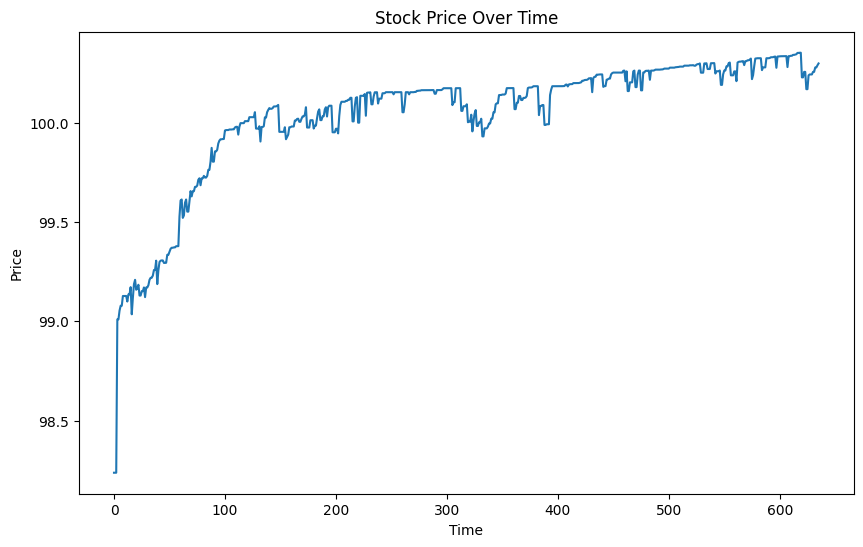

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(order_book.historical_prices)
plt.title('Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

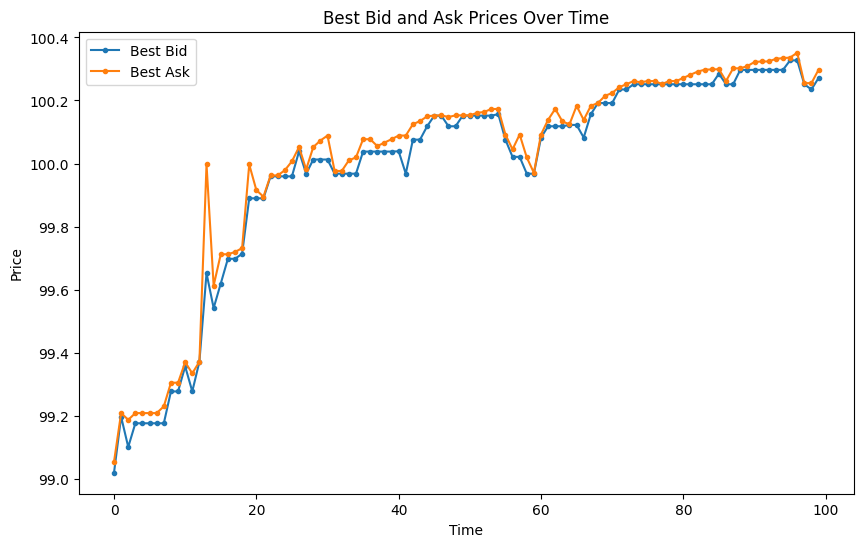

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_bid_prices, label='Best Bid', linestyle='-', marker='.')
plt.plot(best_ask_prices, label='Best Ask', linestyle='-', marker='.')
plt.title('Best Bid and Ask Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

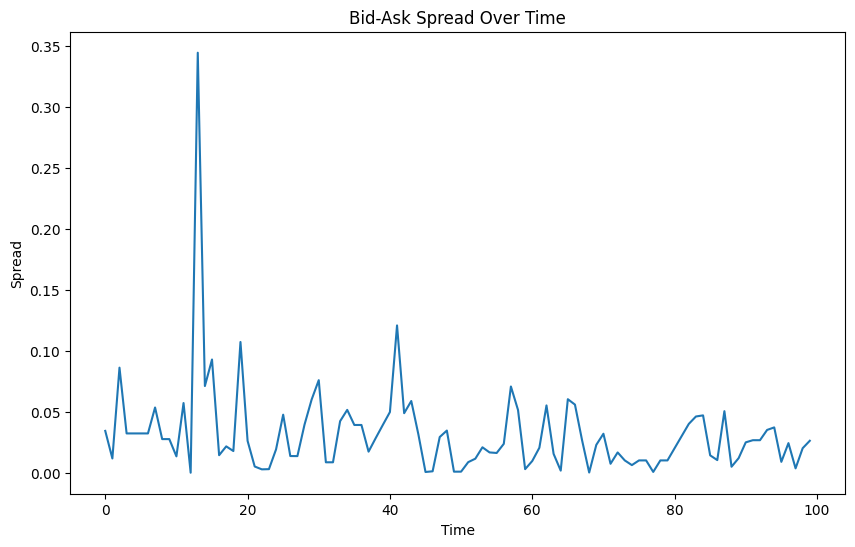

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(spread_over_time)
plt.title('Bid-Ask Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.show()